In [1]:
%cd ..

/nfs/scistore16/edelgrp/fzimin/depth-poset


/mnt/nfs/clustersw/Debian/bookworm/jupyterhub/1.0/lib/python3.11/site-packages/IPython/core/magics/osm.py:417: UserWarning: This is now an optional IPython functionality, setting dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


In [2]:
import os

import numpy as np
import pandas as pd
import pickle as pkl
import networkx as nx
import gudhi as gh

from src.depth import DepthPoset


#from tqdm.notebook import tqdm
from tqdm import tqdm

from matplotlib import pyplot as plt
from matplotlib import cm
from networkx import draw_networkx
from matplotlib.colors import Normalize
from matplotlib.cm import ScalarMappable

from src.depth import DepthPoset

# Load and Format the Data

In [3]:
# define file paths
directory = "results/scores-on-random-alpha-complexes"
paths = np.sort([f'{directory}/{f}' for f in os.listdir(directory)])

paths = paths[pd.Series(paths).apply(lambda s: s.split('.')[0].split('/')[-1]).values > '2024-12-26 18:04:00']

# load them
ls = []
for path in tqdm(paths, total=len(paths)):
    with open(path, 'rb') as file:
        ls.append(pkl.load(file))

100%|██████████| 1114/1114 [00:05<00:00, 216.81it/s]


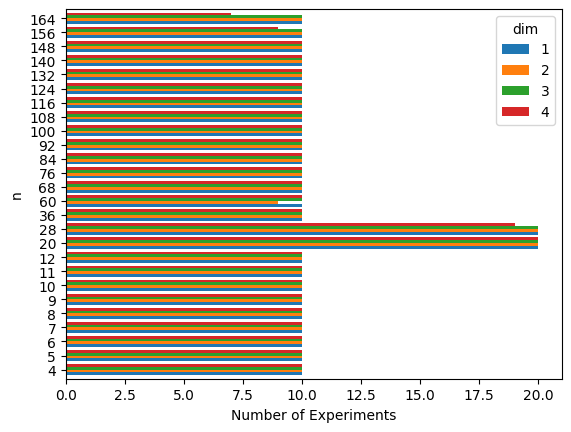

In [4]:
df_cases = pd.DataFrame(ls)
df_cases.insert(0, 'index', df_cases.index)

df_cases[['n', 'dim', 'depth poset']].groupby(['n', 'dim']).count().reset_index().pivot(columns='dim', index='n', values='depth poset').fillna(0).astype(int).plot(kind='barh', width=0.8)
plt.xlabel('Number of Experiments')
plt.savefig('raports/pics/scores - cases.png')

In [5]:
print(f'df_cases.shape = {df_cases.shape}')
df_cases.head()

df_cases.shape = (1114, 8)


,index,n,dim,points,stree,depth poset,poset scores,node scores
0,0,20,1,"[[0.10305157623137906], [0.38120677208072273],...",<gudhi.simplex_tree.SimplexTree object at 0x7f...,<src.depth.DepthPoset object at 0x7f4df8c3c590>,"[{'object': 'full', 'number_of_nodes': 19, 'nu...","[{'object': 'full', 'node': ShallowPair([0.000..."
1,1,20,1,"[[0.018697675883922016], [0.5565212268428941],...",<gudhi.simplex_tree.SimplexTree object at 0x7f...,<src.depth.DepthPoset object at 0x7f4df8adef90>,"[{'object': 'full', 'number_of_nodes': 19, 'nu...","[{'object': 'full', 'node': ShallowPair([0.000..."
2,2,20,1,"[[0.952886259225562], [0.5026184578358628], [0...",<gudhi.simplex_tree.SimplexTree object at 0x7f...,<src.depth.DepthPoset object at 0x7f4df8aecbd0>,"[{'object': 'full', 'number_of_nodes': 19, 'nu...","[{'object': 'full', 'node': ShallowPair([0.000..."
3,3,20,1,"[[0.38242894667808525], [0.28804553836228486],...",<gudhi.simplex_tree.SimplexTree object at 0x7f...,<src.depth.DepthPoset object at 0x7f4df8aee690>,"[{'object': 'full', 'number_of_nodes': 19, 'nu...","[{'object': 'full', 'node': ShallowPair([0.000..."
4,4,20,1,"[[0.3770151514847059], [0.823890916638853], [0...",<gudhi.simplex_tree.SimplexTree object at 0x7f...,<src.depth.DepthPoset object at 0x7f4df8af82d0>,"[{'object': 'full', 'number_of_nodes': 19, 'nu...","[{'object': 'full', 'node': ShallowPair([0.000..."


# Are they Trees

In [6]:
df_cases['is tree'] = [len(nx.cycle_basis(dp.get_transitive_reduction().to_undirected())) == 0 for dp in tqdm(df_cases['depth poset'], total=len(df_cases))]
print(f"There are {df_cases['is tree'].count() - df_cases['is tree'].sum()}/{df_cases['is tree'].count()} depth posets are not trees.")

100%|██████████| 1114/1114 [00:07<00:00, 148.25it/s]

There are 728/1114 depth posets are not trees.


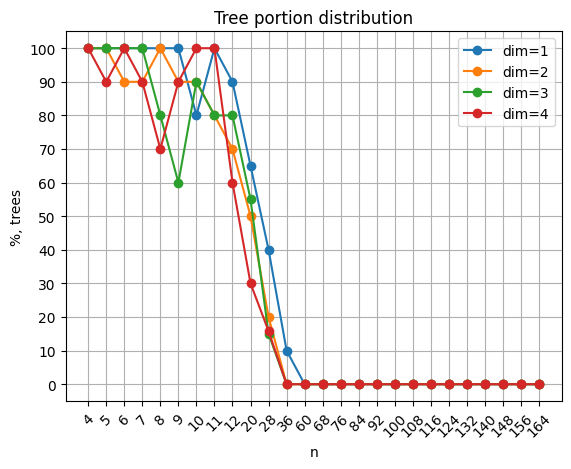

In [7]:
plt.title('Tree portion distribution')

for dim in pd.unique(df_cases['dim']):
    y = df_cases.loc[df_cases['dim'] == dim, ['n', 'is tree']].groupby('n').sum()/df_cases.loc[df_cases['dim'] == dim, ['n', 'is tree']].groupby('n').count()
    plt.plot(np.arange(len(y)), 100*y, label=f'dim={dim}', marker='o')
plt.legend()
plt.xticks(np.arange(len(y)), labels=y.index, rotation=45)
plt.xlabel('n')
plt.yticks(np.arange(0, 101, 10))
plt.ylabel('%, trees')

plt.grid(True)
plt.show()

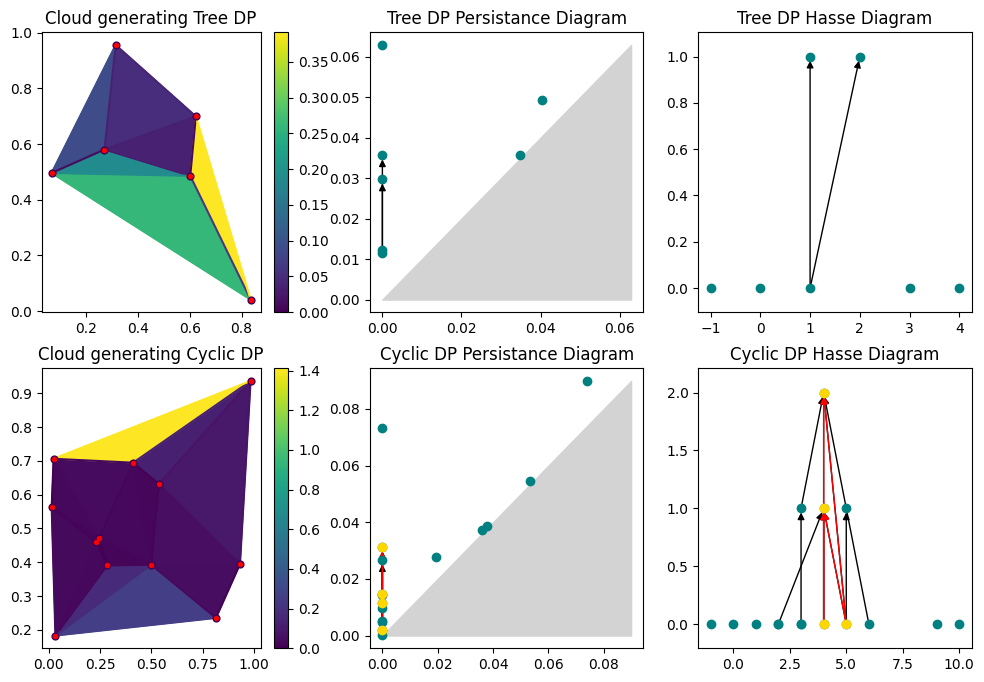

In [8]:
upper_n = 30
try:
    id_tree = np.random.choice(df_cases[df_cases['is tree']&(df_cases['dim'] == 2)&(df_cases['n'] <=upper_n)].index)
    dp_tree = df_cases.loc[id_tree, "depth poset"]
    st_tree = df_cases.loc[id_tree, "stree"]
    ps_tree = df_cases.loc[id_tree, "points"]
except ValueError as msg:
    print(f'Not found tree depth poset dim=2: {msg}')
    dp_tree = DepthPoset()
    st_tree = gh.SimplexTree()
    ps_tree = []
try:
    id_cyclic = np.random.choice(df_cases[(~df_cases['is tree'])&(df_cases['dim'] == 2)&(df_cases['n'] <=upper_n)].index)
    dp_cyclic = df_cases.loc[id_cyclic, "depth poset"]
    st_cyclic = df_cases.loc[id_cyclic, "stree"]
    ps_cyclic = df_cases.loc[id_cyclic, "points"]
except ValueError as msg:
    print(f'Not found cyclic depth poset dim=2: {msg}')
    dp_cyclic = DepthPoset()
    st_cyclic = gh.SimplexTree()
    ps_cyclic = []

titles = ["Tree", "Cyclic"]
dps = [dp_tree, dp_cyclic]
sts = [st_tree, st_cyclic]
pss = [ps_tree, ps_cyclic]


cmap = plt.get_cmap("viridis")

fig, axs = plt.subplots(2, 3)
fig.set_figheight(8)
fig.set_figwidth(12)

for i in range(2):
    axs[i, 0].set_title(f'Cloud generating {titles[i]} DP')
    points, stree = pss[i], sts[i]

    norm = Normalize(vmin=0, vmax=max([value for simplex, value in stree.get_filtration()]))
    for simplex, value in stree.get_filtration():
        color = cmap(norm(value))
        if len(simplex) == 1:
            x, y = points[simplex][0]*np.ones(2)
            axs[i, 0].scatter(x, y, color=color, s=24, zorder=2)
            axs[i, 0].scatter(x, y, color='red', s=8, zorder=3)
        if len(simplex) == 2:
            x, y = np.transpose(points[simplex]*np.ones([2, 2]))
            axs[i, 0].plot(x, y, color=color, zorder=1)
        if len(simplex) == 3:
            x, y = points[simplex].transpose()
            axs[i, 0].fill(x, y, color=color, zorder=0)
    sm = ScalarMappable(cmap=cmap, norm=norm)
    cbar = plt.colorbar(sm, ax=axs[i, 0])

    axs[i, 1].set_title(f'{titles[i]} DP Persistance Diagram')

    g = dps[i].get_transitive_reduction().to_undirected()
    cycles = nx.cycle_basis(g)
    if len(cycles) == 0:
        cycle_nodes = []
        cycle_edges = []
    else:
        cycle_nodes = [] if len(cycles) == 0 else np.concatenate(cycles)
        cycle_edges = np.concatenate([np.array([cycle, np.append(cycle[1:], cycle[0])]) for cycle in cycles], axis=1)
        cycle_edges = np.concatenate([cycle_edges, [cycle_edges[1], cycle_edges[0]]], axis=1).transpose()
        cycle_edges = [tuple(edge) for edge in cycle_edges]
    node_condition = lambda node: node in cycle_nodes
    edge_condition = lambda edge: edge in cycle_edges

    nx.draw_networkx(dps[i].get_transitive_reduction(), 
                     pos=dps[i].persistant_layout(), ax=axs[i, 1], 
                     node_color='teal', edge_color='black',
                     node_size=36, with_labels=False, hide_ticks=False)
    nx.draw_networkx(dps[i].subposet(node_condition=node_condition, edge_condition=edge_condition).get_transitive_reduction(), 
                     pos=dps[i].persistant_layout(), ax=axs[i, 1], 
                     node_color='gold', edge_color='red',
                     node_size=36, with_labels=False, hide_ticks=False)
    
    axs[i, 1].fill_between([0, max(dps[i].get_filtration_values())], [0, max(dps[i].get_filtration_values())], [0, 0], color='lightgrey')
    axs[i, 1].set_xlim(*(np.max(dps[i].get_filtration_values())*np.array([-0.05, 1.05])))
    axs[i, 1].set_ylim(*(np.max(dps[i].get_filtration_values())*np.array([-0.05, 1.05])))

    
    axs[i, 2].set_title(f'{titles[i]} DP Hasse Diagram')

    nx.draw_networkx(dps[i].get_transitive_reduction(), 
                     pos=dps[i].hasse_layout(), ax=axs[i, 2], 
                     node_color='teal', edge_color='black',
                     node_size=36, with_labels=False, hide_ticks=False)
    nx.draw_networkx(dps[i].subposet(node_condition=node_condition, edge_condition=edge_condition).get_transitive_reduction(), 
                     pos=dps[i].hasse_layout(), ax=axs[i, 2], 
                     node_color='gold', edge_color='red',
                     node_size=36, with_labels=False, hide_ticks=False)

plt.show()

# Plot Poset scores

In [9]:
from src import poset_scores

In [10]:
df_poset_scores = [pd.DataFrame(i['poset scores']) for i in ls]
for i in range(len(df_poset_scores)):
    df_poset_scores[i].insert(0, 'index', value=i)
df_poset_scores = pd.concat(df_poset_scores)

df_poset_scores = df_cases[['index', 'n', 'dim']].join(df_poset_scores.set_index('index'), on='index')
df_poset_scores = df_poset_scores.reset_index(drop=True)

print(f'df_poset_scores.shape = {df_poset_scores.shape}')
df_poset_scores.head()

df_poset_scores.shape = (3892, 11)


,index,n,dim,object,number_of_nodes,number_of_minimal_nodes,number_of_maximal_nodes,height,width,minimum_maximal_chain,avarage_maximal_chain
0,0,20,1,full,19,9,4,4,9,1,2.70
1,0,20,1,subposet dim=0,19,9,4,4,9,1,2.70
2,1,20,1,full,19,10,1,3,10,3,3.70
3,1,20,1,subposet dim=0,19,10,1,3,10,3,3.70
4,2,20,1,full,19,11,1,4,11,3,3.75


In [11]:
interesting_poset_scores = [poset_scores.number_of_nodes, 
                            poset_scores.number_of_relations, 
                            poset_scores.number_of_compounds, 
                            poset_scores.cycle_dimension, 
                            poset_scores.number_of_minimal_nodes, 
                            poset_scores.number_of_maximal_nodes, 
                            poset_scores.height, 
                            poset_scores.width, 
                            poset_scores.minimum_maximal_chain, 
                            poset_scores.avarage_maximal_chain
                           ]
interesting_poset_scores_names = [score.__name__ for score in interesting_poset_scores]

for score in interesting_poset_scores:
    if not (score.__name__ in df_poset_scores.columns):
        df_poset_scores[score.__name__] = np.nan

missed_values = df_poset_scores[[score.__name__ for score in interesting_poset_scores]].isna().sum().sum()
print(f'There are {missed_values} values missed and should be restored.')
with tqdm(total=missed_values) as pbar:
    for i in df_poset_scores.index:
        if df_poset_scores.loc[i, interesting_poset_scores_names].isna().any():
            dp = df_cases.loc[df_cases['index'] == df_poset_scores.loc[i, 'index'], 'depth poset'].values[0]
            if df_poset_scores.loc[i, 'object'] != 'full':
                dim = int(df_poset_scores.loc[i, 'object'].replace('subposet dim=', ''))
                dp = dp.subposet_dim(dim)
            for score in interesting_poset_scores:
                if pd.isna(df_poset_scores.loc[i, score.__name__]):
                    df_poset_scores.loc[i, score.__name__] = score(dp)
                    pbar.update()
        
print(f'df_poset_scores.shape = {df_poset_scores.shape}')
df_poset_scores.head()

There are 11676 values missed and should be restored.


100%|██████████| 11676/11676 [01:14<00:00, 156.07it/s] 

df_poset_scores.shape = (3892, 14)


,index,n,dim,object,number_of_nodes,number_of_minimal_nodes,number_of_maximal_nodes,height,width,minimum_maximal_chain,avarage_maximal_chain,number_of_relations,number_of_compounds,cycle_dimension
0,0,20,1,full,19,9,4,4,9,1,2.70,16.0,3.0,0.0
1,0,20,1,subposet dim=0,19,9,4,4,9,1,2.70,16.0,3.0,0.0
2,1,20,1,full,19,10,1,3,10,3,3.70,18.0,1.0,0.0
3,1,20,1,subposet dim=0,19,10,1,3,10,3,3.70,18.0,1.0,0.0
4,2,20,1,full,19,11,1,4,11,3,3.75,19.0,1.0,1.0


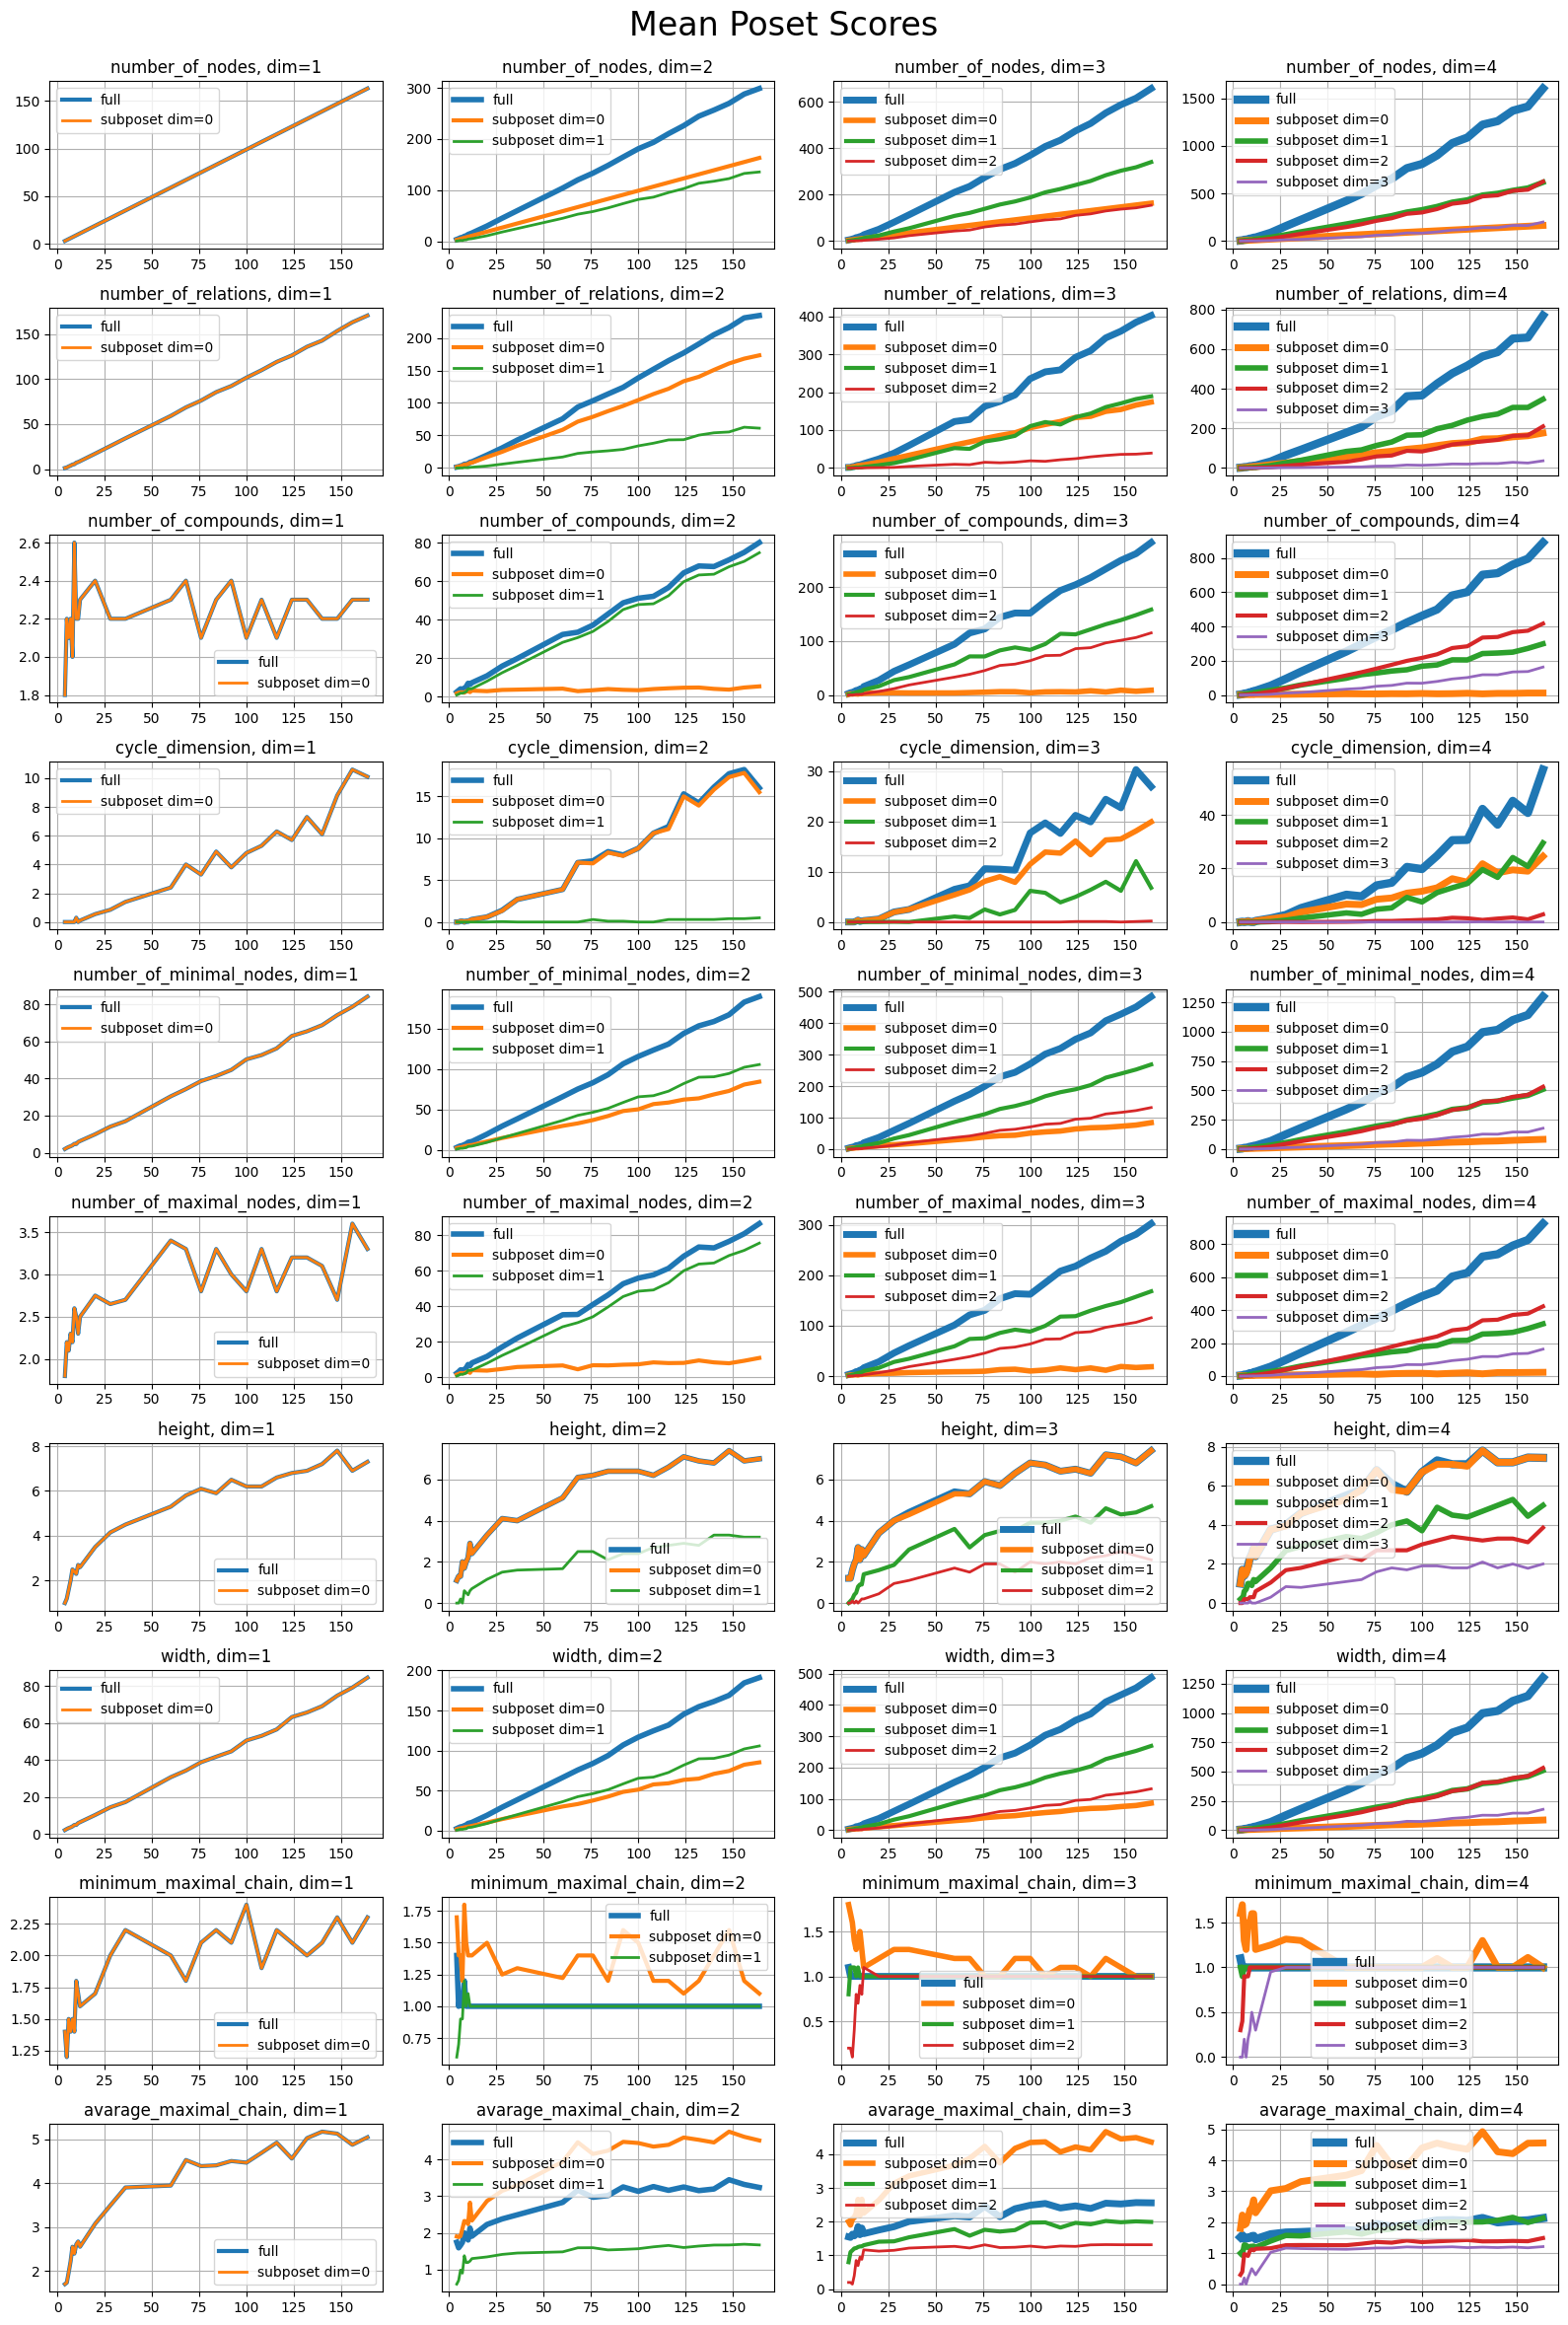

In [12]:
#score_cols = df_poset_scores.columns[4:]
score_cols = interesting_poset_scores_names
max_dim = df_poset_scores['dim'].max()

fig, axs = plt.subplots(len(score_cols), max_dim)

fig.suptitle('Mean Poset Scores', fontsize=24)
fig.set_figwidth(16)
fig.set_figheight(24)

for iscore, score in enumerate(score_cols):
    for dim in range(1, max_dim + 1):
        title = f'{score}, dim={dim}'
        axs[iscore, dim - 1].set_title(title)
        df_use = df_poset_scores[df_poset_scores['dim'] == dim][['n', 'object', score]].groupby(['n', 'object']).mean().reset_index().pivot(columns='object', index='n', values=score)
        for icol, col in enumerate(df_use.columns):
            axs[iscore, dim - 1].plot(df_use.index, df_use[col], label=col, linewidth=(len(df_use.columns) + 1 - icol))
        axs[iscore, dim - 1].legend()
        axs[iscore, dim - 1].grid(True)
        
plt.tight_layout()
plt.subplots_adjust(top=0.95)

plt.savefig('raports/pics/scores - mean poset scores.png')

# Plot Node Scores

In [13]:
from src import node_scores

In [14]:
df_node_scores = [pd.DataFrame(i['node scores']) for i in ls]
for i in range(len(df_node_scores)):
    df_node_scores[i].insert(0, 'index', value=i)
df_node_scores = pd.concat(df_node_scores)


df_node_scores = df_cases[['index', 'n', 'dim']].join(df_node_scores.set_index('index'), on='index')

print(f'df_node_scores.shape = {df_node_scores.shape}')
df_node_scores.head()

df_node_scores.shape = (31614, 12)


,index,n,dim,object,node,incomparable_number,ancestors_number,ancestors_height,ancestors_width,successors_number,successors_height,successors_width
0,0,20,1,full,"ShallowPair([0.0000, 0.0001], dim=0)",14,2,1,1,2,1,1
0,0,20,1,subposet dim=0,"ShallowPair([0.0000, 0.0001], dim=0)",14,2,1,1,2,1,1
0,0,20,1,full,"ShallowPair([0.0000, 0.0034], dim=0)",14,1,0,1,3,1,2
0,0,20,1,subposet dim=0,"ShallowPair([0.0000, 0.0034], dim=0)",14,1,0,1,3,1,2
0,0,20,1,full,"ShallowPair([0.0000, 0.0002], dim=0)",15,3,1,2,0,0,0


In [15]:
interesting_node_scores = [node_scores.ancestors_number, 
                            node_scores.ancestors_height, 
                            node_scores.ancestors_width, 
                            node_scores.successors_number, 
                            node_scores.successors_height, 
                            node_scores.successors_width, 
                           ]
interesting_node_scores_names = [score.__name__ for score in interesting_node_scores]

for score in interesting_node_scores:
    if not (score.__name__ in df_node_scores.columns):
        df_node_scores[score.__name__] = np.nan

missed_values = df_node_scores[[score.__name__ for score in interesting_node_scores]].isna().sum().sum()
print(f'There are {missed_values} values missed and should be restored.')

with tqdm(total=missed_values) as pbar:
    pass
        
print(f'df_node_scores.shape = {df_node_scores.shape}')
df_node_scores.head()

There are 0 values missed and should be restored.


0it [00:00, ?it/s]

df_node_scores.shape = (31614, 12)


,index,n,dim,object,node,incomparable_number,ancestors_number,ancestors_height,ancestors_width,successors_number,successors_height,successors_width
0,0,20,1,full,"ShallowPair([0.0000, 0.0001], dim=0)",14,2,1,1,2,1,1
0,0,20,1,subposet dim=0,"ShallowPair([0.0000, 0.0001], dim=0)",14,2,1,1,2,1,1
0,0,20,1,full,"ShallowPair([0.0000, 0.0034], dim=0)",14,1,0,1,3,1,2
0,0,20,1,subposet dim=0,"ShallowPair([0.0000, 0.0034], dim=0)",14,1,0,1,3,1,2
0,0,20,1,full,"ShallowPair([0.0000, 0.0002], dim=0)",15,3,1,2,0,0,0


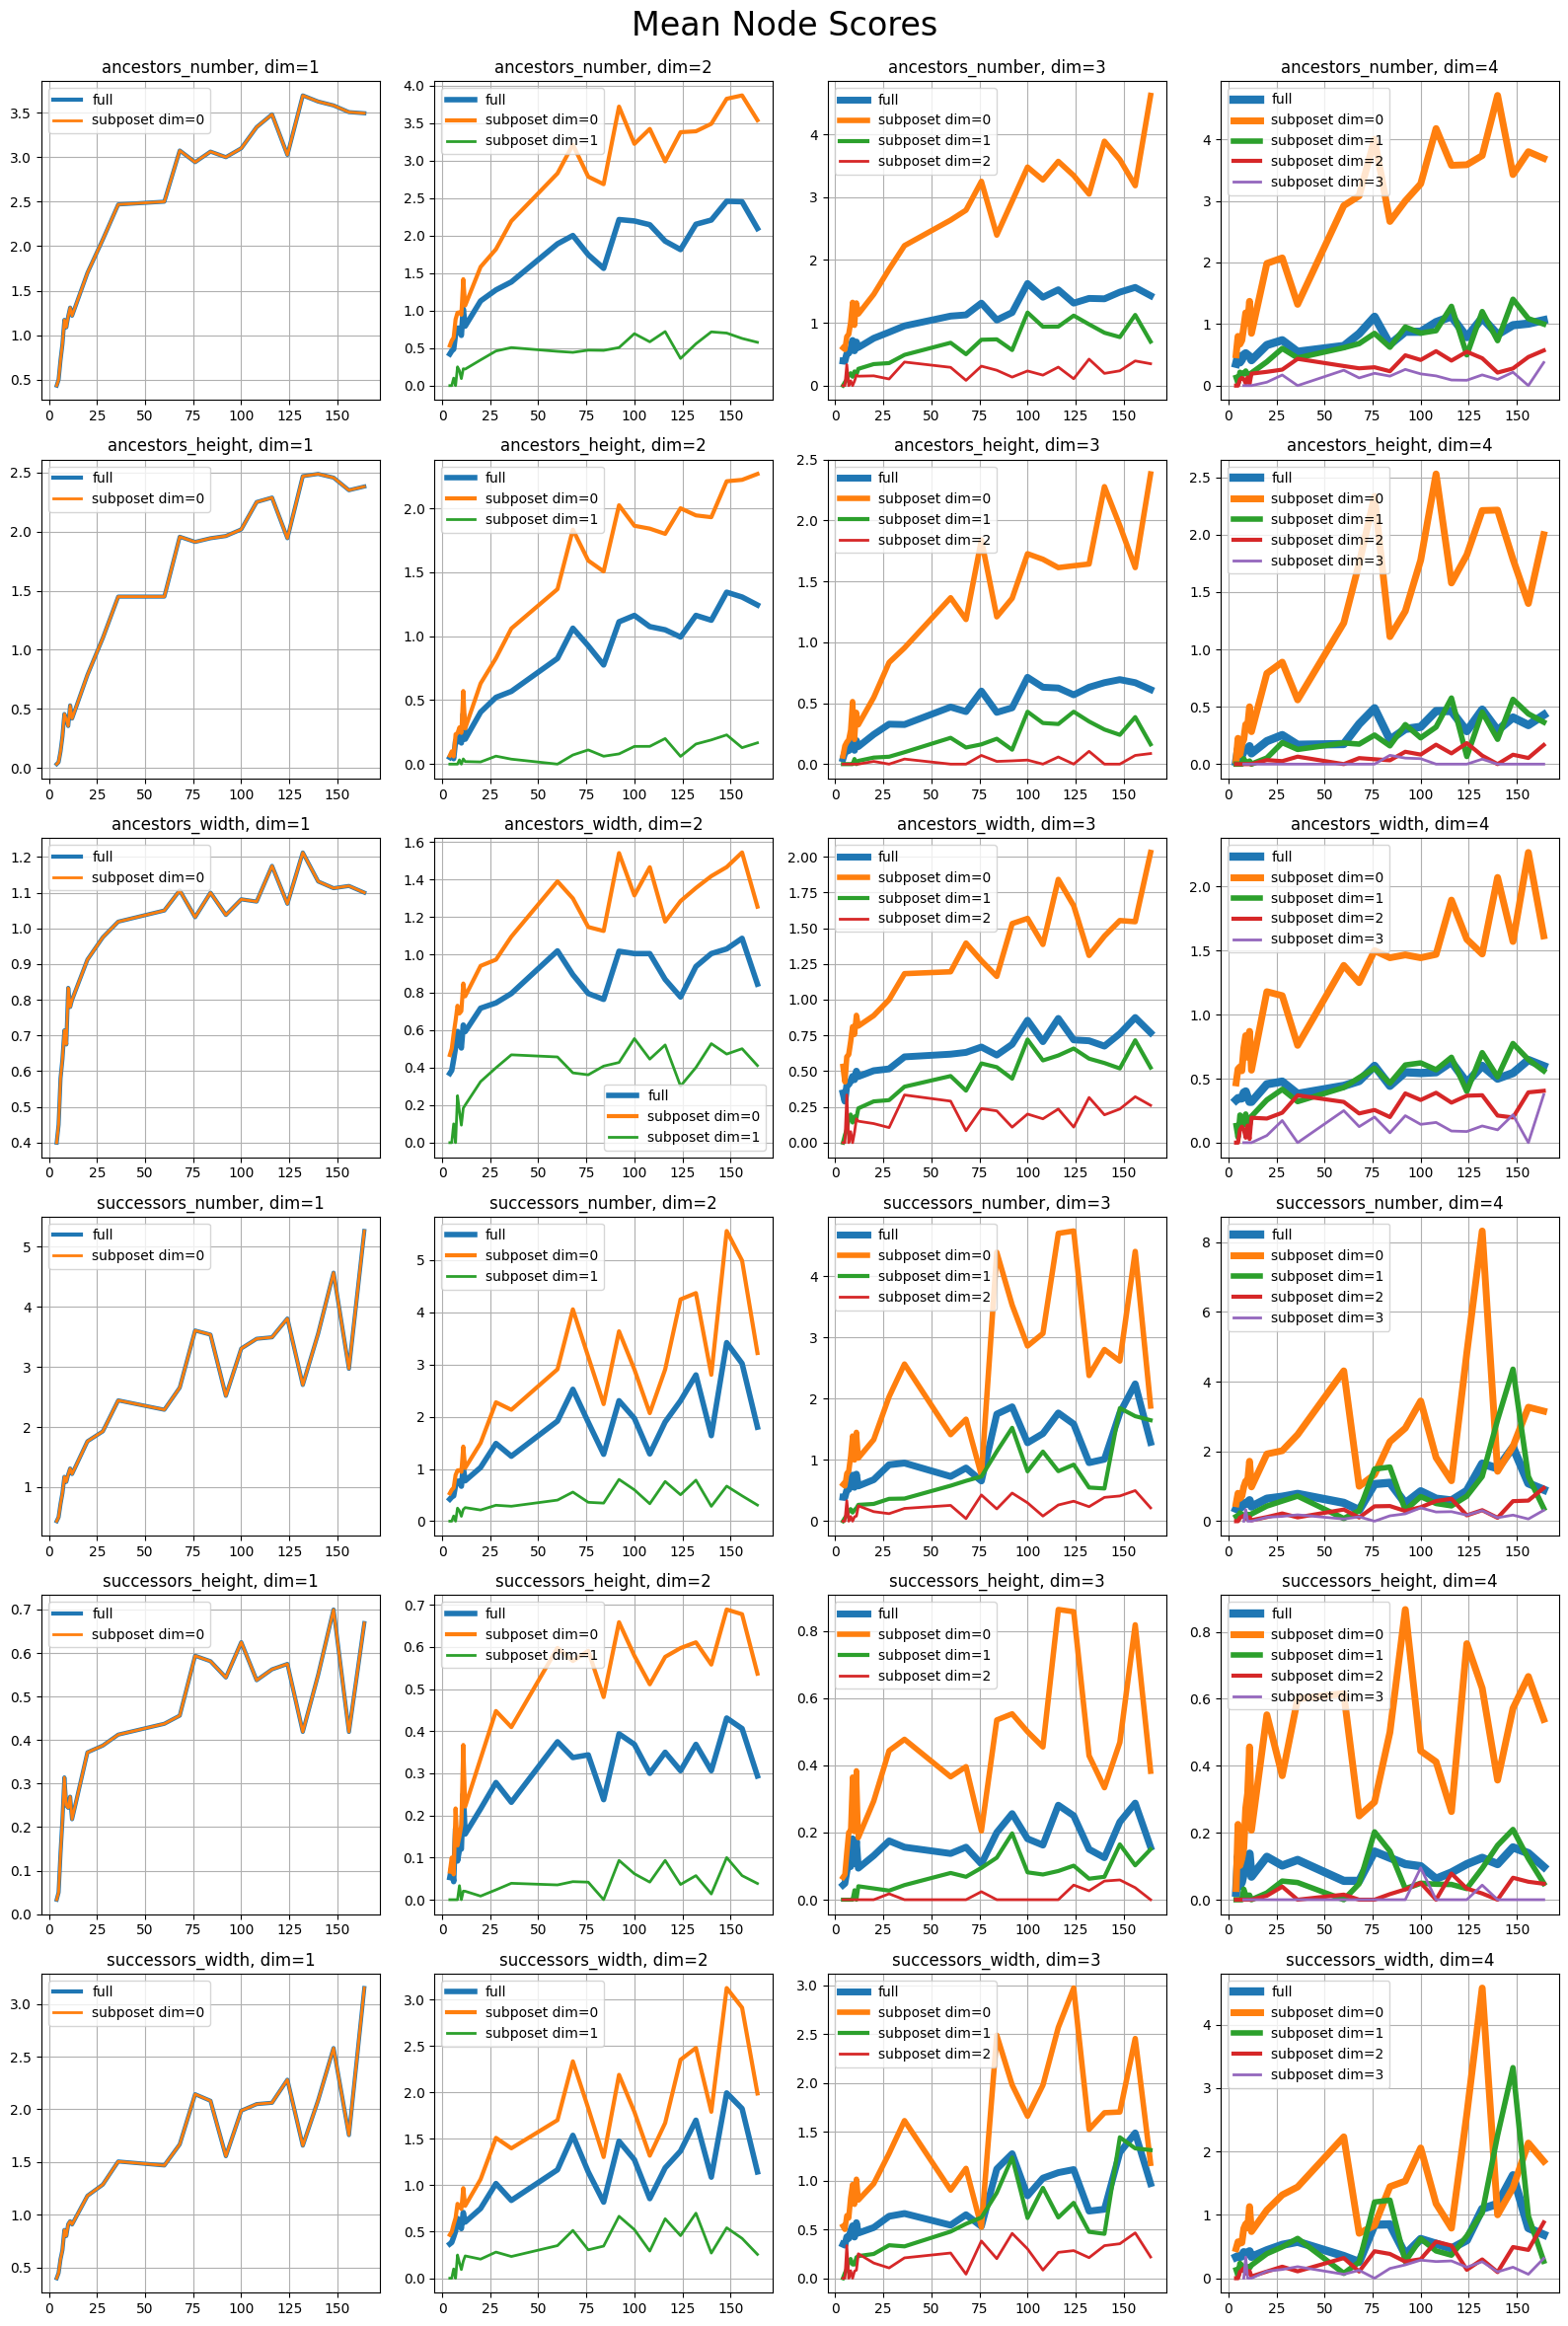

In [16]:
score_cols = interesting_node_scores_names

max_dim = df_node_scores['dim'].max()

fig, axs = plt.subplots(len(score_cols), max_dim)

fig.suptitle('Mean Node Scores', fontsize=24)
fig.set_figwidth(16)
fig.set_figheight(24)

for iscore, score in enumerate(score_cols):
    for dim in range(1, max_dim + 1):
        title = f'{score}, dim={dim}'
        axs[iscore, dim - 1].set_title(title)
        df_use = df_node_scores[df_node_scores['dim'] == dim][['n', 'object', score]].groupby(['n', 'object']).mean('score').reset_index().pivot(columns='object', index='n', values=score)
        for icol, col in enumerate(df_use.columns):
            axs[iscore, dim - 1].plot(df_use.index, df_use[col], label=col, linewidth=(len(df_use.columns) + 1 - icol))
        axs[iscore, dim - 1].legend()
        axs[iscore, dim - 1].grid(True)
        
plt.tight_layout()
plt.subplots_adjust(top=0.95)

plt.savefig('raports/pics/scores - mean node scores.png')

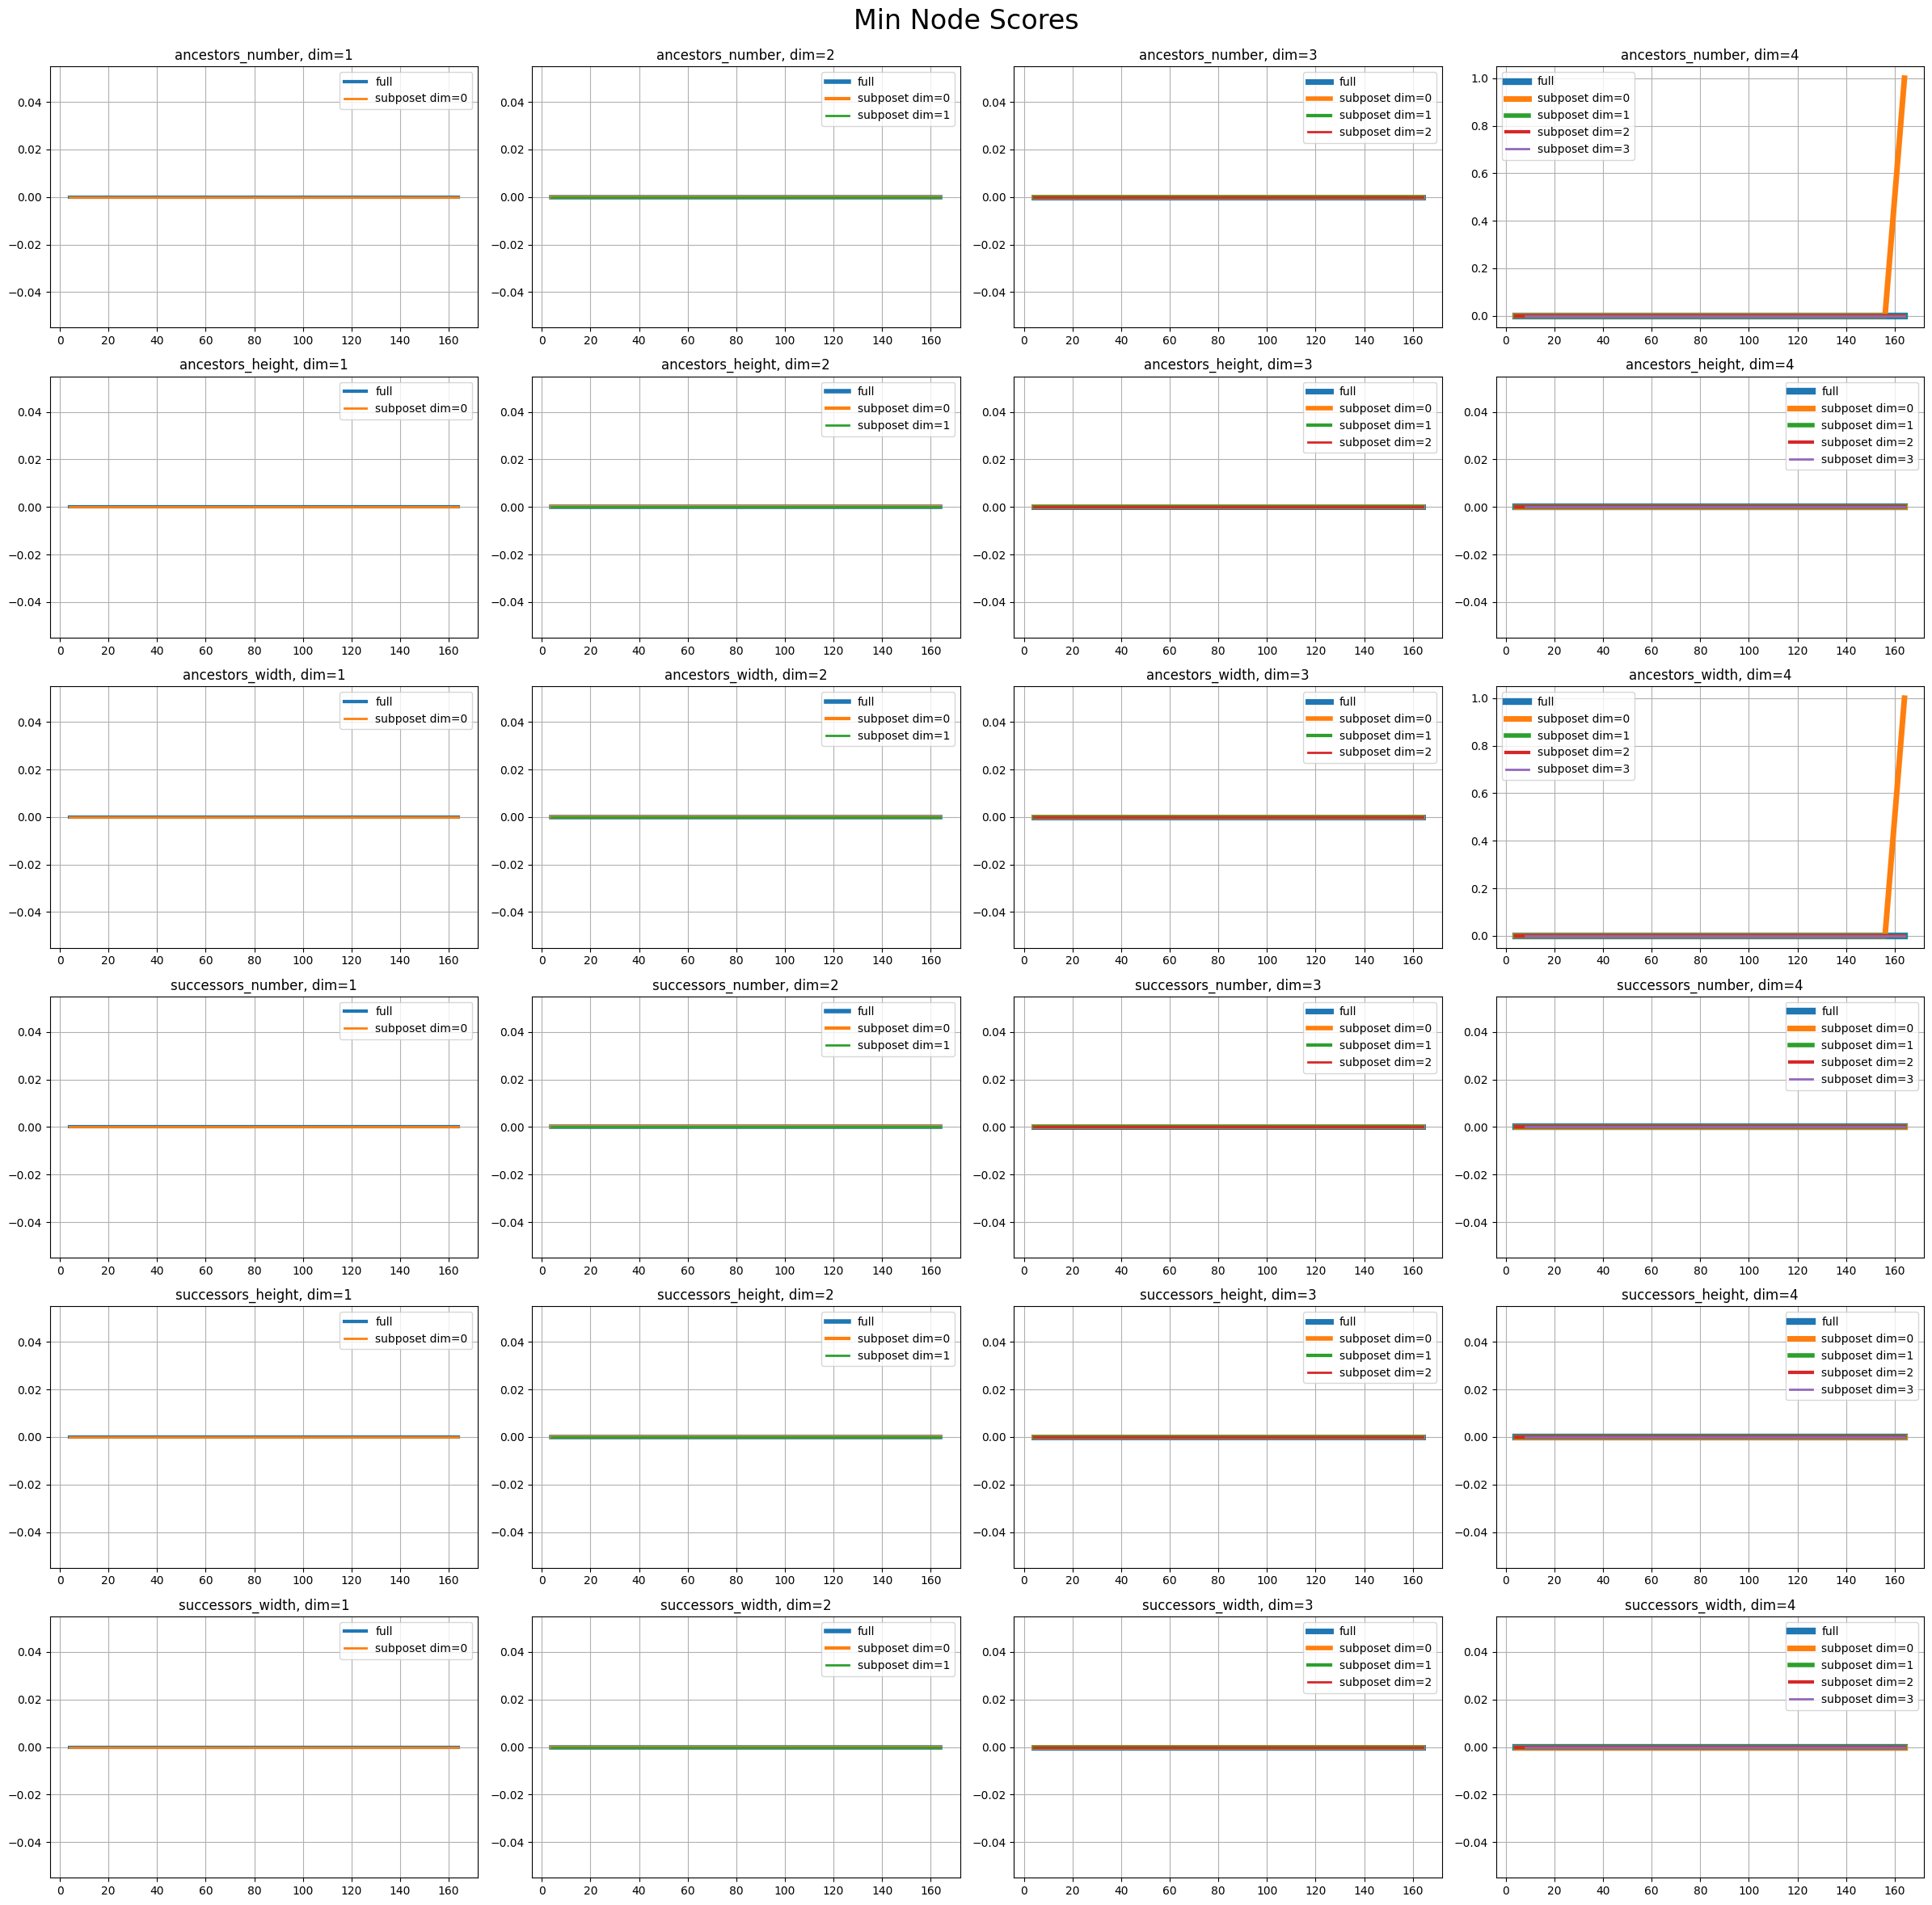

In [17]:
score_cols = interesting_node_scores_names
max_dim = df_node_scores['dim'].max()

fig, axs = plt.subplots(len(score_cols), max_dim)

fig.suptitle('Min Node Scores', fontsize=24)
fig.set_figwidth(24)
fig.set_figheight(24)

for iscore, score in enumerate(score_cols):
    for dim in range(1, max_dim + 1):
        title = f'{score}, dim={dim}'
        axs[iscore, dim - 1].set_title(title)
        df_use = df_node_scores[df_node_scores['dim'] == dim][['n', 'object', score]].groupby(['n', 'object']).min().reset_index().pivot(columns='object', index='n', values=score)
        for icol, col in enumerate(df_use.columns):
            axs[iscore, dim - 1].plot(df_use.index, df_use[col], label=col, linewidth=(len(df_use.columns) + 1 - icol))
        axs[iscore, dim - 1].legend()
        axs[iscore, dim - 1].grid(True)
        
plt.tight_layout()
plt.subplots_adjust(top=0.95)

plt.savefig('raports/pics/scores - min node scores.png')

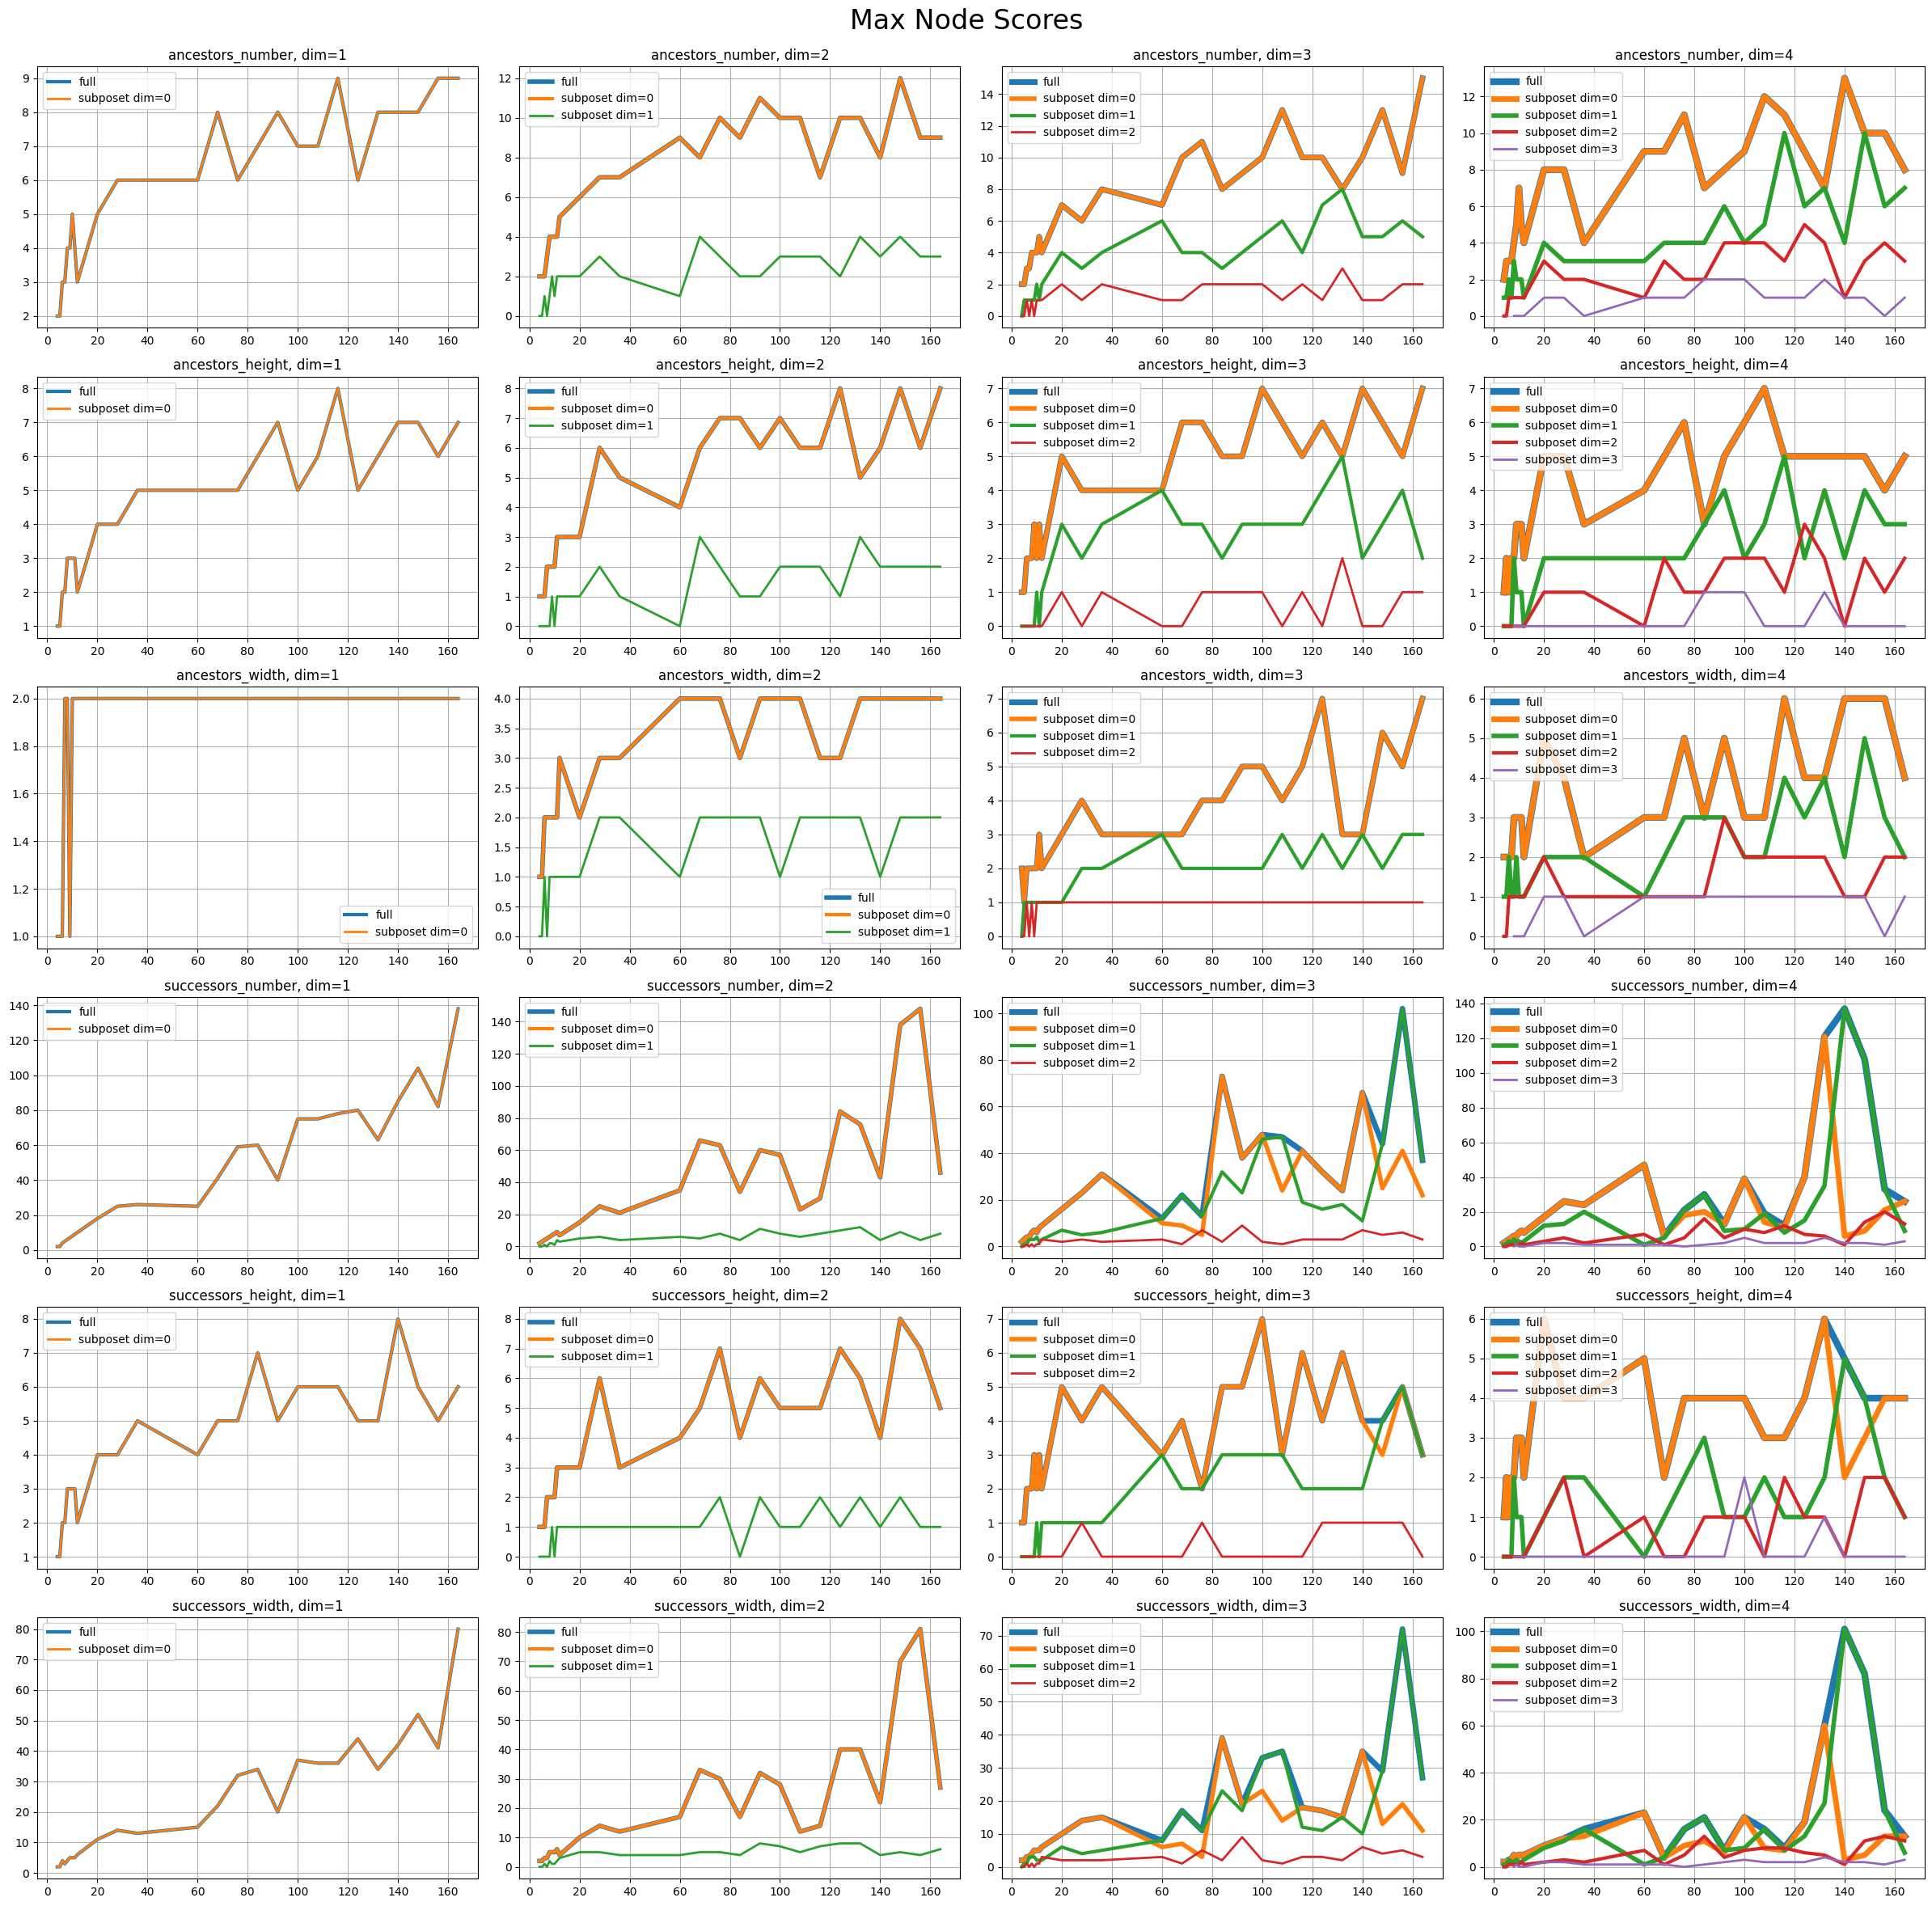

In [18]:
score_cols = interesting_node_scores_names
max_dim = df_node_scores['dim'].max()

fig, axs = plt.subplots(len(score_cols), max_dim)

fig.suptitle('Max Node Scores', fontsize=24)
fig.set_figwidth(24)
fig.set_figheight(24)

for iscore, score in enumerate(score_cols):
    for dim in range(1, max_dim + 1):
        title = f'{score}, dim={dim}'
        axs[iscore, dim - 1].set_title(title)
        df_use = df_node_scores[df_node_scores['dim'] == dim][['n', 'object', score]].groupby(['n', 'object']).max().reset_index().pivot(columns='object', index='n', values=score)
        for icol, col in enumerate(df_use.columns):
            axs[iscore, dim - 1].plot(df_use.index, df_use[col], label=col, linewidth=(len(df_use.columns) + 1 - icol))
        axs[iscore, dim - 1].legend()
        axs[iscore, dim - 1].grid(True)
        
plt.tight_layout()
plt.subplots_adjust(top=0.95)

plt.savefig('raports/pics/scores - max node scores.png')

# Compile Raport Document

In [19]:
import src.poset_scores as poset_scores
import src.node_scores as node_scores
import inspect

In [20]:
def href_links(s: str, text='link') -> str:
    # replacing links in string with LaTeX format
    for w in s.split():
        if w[:6] == r'https:':
            if text is None:
                s = s.replace(w, f'\href{{{w}}}' + f'{{{w}}}'.replace('_', r'\_'))
            else:
                s = s.replace(w, f'\href{{{w}}}' + f'{{{text}}}')
    return s

In [30]:
# poset_scores description
s_poset_scores = r'\begin{itemize}' + '\n'

#for name, obj in inspect.getmembers(poset_scores, inspect.isfunction):
for obj, name in zip(interesting_poset_scores, interesting_poset_scores_names):
    if obj.__module__ == poset_scores.__name__:
        s_poset_scores += r"\item \textbf{" + name.replace('_', r'\_') + " }: " + href_links(obj.__doc__.strip()) + "\n"
s_poset_scores += r'\end{itemize}'

print(s_poset_scores)

\begin{itemize}
\item \textbf{number\_of\_nodes }: Returns the number of nodes in the poset.
\item \textbf{number\_of\_relations }: Returns the number of relations in the transitive reduction.
\item \textbf{number\_of\_compounds }: Returns the number of connetcted compounds in the poset
\item \textbf{cycle\_dimension }: Returns the dimension of space of cycles in reduction.
\item \textbf{number\_of\_minimal\_nodes }: Returns the number of minimal nodes.
\item \textbf{number\_of\_maximal\_nodes }: Returns the number of maximal nodes.
\item \textbf{height }: Returns the poset height - the length of the longest chain.
\item \textbf{width }: Returns the poset width - the length of the longest antichain (subset, s.t. all elements are pairwise incomparable).
    The algorithm is based on Dilworth's theorem and it's proof via Kőnig's theorem:
    \href{https://en.wikipedia.org/wiki/Dilworth%27s_theorem}{link}
\item \textbf{minimum\_maximal\_chain }: Returns the minimum size of maximal chains 

In [31]:
# node_scores description
s_node_scores = r'\begin{itemize}' + '\n'

#for name, obj in inspect.getmembers(node_scores, inspect.isfunction):
for obj, name in zip(interesting_node_scores, interesting_node_scores_names):
    if obj.__module__ == node_scores.__name__:
        s_node_scores += r"\item \textbf{" + name.replace('_', r'\_') + "}: " + href_links(obj.__doc__.strip()) + "\n"
s_node_scores += r'\end{itemize}'

print(s_node_scores)

\begin{itemize}
\item \textbf{ancestors\_number}: Returns the number of nodes higher than given
\item \textbf{ancestors\_height}: Returns the size of maximum chain of subposet of nodes higher or equal than given
\item \textbf{ancestors\_width}: Returns the size of maximum chain of subposet of nodes higher or equal than given
\item \textbf{successors\_number}: Returns the number of nodes higher than given
\item \textbf{successors\_height}: Returns the size of maximum chain of subposet of nodes lower or equal than given
\item \textbf{successors\_width}: Returns the size of maximum chain of subposet of nodes lower or equal than given
\end{itemize}


In [32]:
# load texts, describing the process
with open('texts/scores - model.txt', 'r') as file:
    s_model = file.read()

with open('texts/scores - conclusion.txt', 'r') as file:
    s_coclusion = file.read()

# load LaTeX template
with open('texts/template.tex', 'r') as file:
    s_latex = file.read()

In [33]:
# parameters to include pictures containing scores
vspace_pt = -48
resize_width = 1.4
hspace_width = min(0, 0.5*(1 - resize_width))




body = f"""
\\section{{Model}}
{s_model}

\\section{{Scores}}
\\subsection{{Poset Scores}}
{s_poset_scores}

\\subsection{{Node Scores}}
{s_node_scores}

\\section{{Experiments and Results}}
\\par There are {len(df_cases)} experiments done. In the Figure \\ref{{fig:cases_distribution}} we can see how cases are distributed by size and dimension.
\\begin{{figure}}[ht]
  \\centering
  \\includegraphics[width=\\textwidth]{{pics/scores - cases.png}}
  \\caption{{Size/dimension distribution of experiments}}
  \\label{{fig:cases_distribution}}
\end{{figure}}

\\par In the Figure \\ref{{fig:scores_poset_mean}} we can see the avarage poset scores values for each number of points $n$.
\\begin{{figure}}[ht]
  \\vspace{{{vspace_pt}pt}}
  \\centering
  \\hspace*{{{hspace_width}\\textwidth}}
  \\resizebox{{{resize_width}\\textwidth}}{{!}}{{\\includegraphics[width=\\textwidth]{{pics/scores - mean poset scores.png}}}}
  \\caption{{Mean poset scores}}
  \\label{{fig:scores_poset_mean}}
\\end{{figure}}

\\par In the Figure \\ref{{fig:scores_node_mean}} we can see the avarage mean node scores values in poset for each number of points $n$.
\\begin{{figure}}[ht]
  \\vspace{{{vspace_pt}pt}}
  \\centering
  \\hspace*{{{hspace_width}\\textwidth}}
  \\resizebox{{{resize_width}\\textwidth}}{{!}}{{\\includegraphics[width=\\textwidth]{{pics/scores - mean node scores.png}}}}
  \\caption{{Mean node scores}}
  \\label{{fig:scores_node_mean}}
\\end{{figure}}

\\par In the Figure \\ref{{fig:scores_node_max}} we can see the avarage maximum node scores values in poset for each number of points $n$.
\\begin{{figure}}[ht]
  \\vspace{{{vspace_pt}pt}}
  \\centering
  \\hspace*{{{hspace_width}\\textwidth}}
  \\resizebox{{{resize_width}\\textwidth}}{{!}}{{\\includegraphics[width=\\textwidth]{{pics/scores - max node scores.png}}}}
  \\caption{{Max node scores}}
  \\label{{fig:scores_node_max}}
\\end{{figure}}

\\section{{Conclusion}}
{s_coclusion}

"""

if len(s_coclusion) == 0:
    body = body[:-24]

raport = s_latex.replace('BODY', body)
print(raport)

\documentclass{article}
\usepackage{amsfonts} 
\usepackage{hyperref}
\usepackage{graphicx}

\begin{document}


\section{Model}
\par The probabilistic model is simple. The first we just generate the cloud of $n$ points uniformly distributed in $[0, 1]^d$. After this we calculate the Alpha complex with these points, and then find its depth poset.

\section{Scores}
\subsection{Poset Scores}
\begin{itemize}
\item \textbf{number\_of\_nodes }: Returns the number of nodes in the poset.
\item \textbf{number\_of\_relations }: Returns the number of relations in the transitive reduction.
\item \textbf{number\_of\_compounds }: Returns the number of connetcted compounds in the poset
\item \textbf{cycle\_dimension }: Returns the dimension of space of cycles in reduction.
\item \textbf{number\_of\_minimal\_nodes }: Returns the number of minimal nodes.
\item \textbf{number\_of\_maximal\_nodes }: Returns the number of maximal nodes.
\item \textbf{height }: Returns the poset height - the length of the l

In [34]:
with open('raports/scores.tex', 'w') as file:
    file.write(raport)

In [35]:
%cd raports
os.system('pdflatex scores.tex')
%cd ..

/nfs/scistore16/edelgrp/fzimin/depth-poset/raports
This is pdfTeX, Version 3.141592653-2.6-1.40.23 (TeX Live 2021) (preloaded format=pdflatex)
 restricted \write18 enabled.


/mnt/nfs/clustersw/Debian/bookworm/jupyterhub/1.0/lib/python3.11/site-packages/IPython/core/magics/osm.py:417: UserWarning: This is now an optional IPython functionality, setting dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


entering extended mode
(./scores.tex
LaTeX2e <2021-06-01> patch level 1
L3 programming layer <2021-10-18>
(/nfs/scistore07/clustersw/shared/texlive/2021/texmf-dist/tex/latex/base/articl
e.cls
Document Class: article 2021/02/12 v1.4n Standard LaTeX document class

(/nfs/scistore07/clustersw/shared/texlive/2021/texmf-dist/tex/latex/base/size10
.clo))
(/nfs/scistore07/clustersw/shared/texlive/2021/texmf-dist/tex/latex/amsfonts/am
sfonts.sty)
(/nfs/scistore07/clustersw/shared/texlive/2021/texmf-dist/tex/latex/hyperref/hy
perref.sty
(/nfs/scistore07/clustersw/shared/texlive/2021/texmf-dist/tex/generic/ltxcmds/l
txcmds.sty)
(/nfs/scistore07/clustersw/shared/texlive/2021/texmf-dist/tex/generic/iftex/ift
ex.sty)
(/nfs/scistore07/clustersw/shared/texlive/2021/texmf-dist/tex/generic/pdftexcmd
s/pdftexcmds.sty
(/nfs/scistore07/clustersw/shared/texlive/2021/texmf-dist/tex/generic/infwarerr
/infwarerr.sty))
(/nfs/scistore07/clustersw/shared/texlive/2021/texmf-dist/tex/latex/graphics/ke
yval.sty)
(/